In [10]:


import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer

def parse_data(file_name):
    features = list()
    labels = list()
    with open(file_name, 'rt') as f:
        f.readline()
        for l in f:
            if bool(re.search("^[0-9]", l)):
                g = re.search("^(([0-9]{1,2},?)+)\s(.*)$", l)
                labels.append([int(i) for i in g.group(1).split(",")])
                features.append(eval("{" + re.sub("\s", ",", g.group(3)) + "}"))
            else:
                l = l.strip()
                labels.append([])
                features.append(eval("{" + re.sub("\s", ",", l) + "}"))
    features = pd.DataFrame.from_dict(features).fillna(0).iloc[:,:].values
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)
    return features, y

X, y = parse_data("data0215.txt")

In [12]:
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, SeparateClassifiers,\
            EpsilonGreedy, AdaptiveGreedy, ExploreFirst, ActiveExplorer, SoftmaxExplorer
from copy import deepcopy

nchoices = y.shape[1]
base_algorithm = LogisticRegression(random_state=123, solver='lbfgs')
beta_prior = ((3, 7), 2) # until there are at least 2 observations of each class, will use prior Beta(3, 7)

## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior)
one_vs_rest = SeparateClassifiers(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior)
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior)
epsilon_greedy_nodecay = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                     beta_prior=beta_prior, decay=None)
adaptive_greedy_thr = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                     decay_type='threshold')
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, percentile=50, beta_prior=beta_prior,
                                      decay_type='percentile', decay=0.3, active_choice='weighted')
explore_first = ExploreFirst(deepcopy(base_algorithm), nchoices = nchoices,
                             beta_prior=None, explore_rounds=1500)
active_explorer = ActiveExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prAdaptiveior=beta_prior)
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                        active_choice='weighted', decay_type='percentile', decay=0.9997)
softmax_explorer = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior)

models = [bootstrapped_ucb, bootstrapped_ts, one_vs_rest, epsilon_greedy, epsilon_greedy_nodecay,
          adaptive_greedy_thr, adaptive_greedy_perc, explore_first, active_explorer,
          adaptive_active_greedy, softmax_explorer]

#models = [adaptive_greedy_perc]

TypeError: __init__() got an unexpected keyword argument 'beta_prAdaptiveior'

In [84]:
# These lists will keep track of the rewards obtained by each policy

# rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2, \
# rewards_agr, rewards_agr2, rewards_efr, rewards_ac, \
# rewards_aac, rewards_sft = [list() for i in range(len(models))]

# lst_rewards = [rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2,
#                rewards_agr, rewards_agr2, rewards_efr, rewards_ac,
#                rewards_aac, rewards_sft]

rewards_agr2 = []
lst_rewards =[rewards_agr2]

# batch size - algorithms will be refit after N rounds
batch_size=100

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    np.random.seed(123)
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose

# lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr, \
# lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, \
# lst_a_sft = [action_chosen.copy() for i in range(len(models))]

# lst_actions = [lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr,
#                lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, lst_a_sft]

lst_a_agr2 = action_chosen.copy()
lst_actions = [lst_a_agr2]

# rounds are simulated from the full dataset
def simulate_rounds(model, rewards, actions_hist, X_global, y_global, batch_st, batch_end):
    np.random.seed(batch_st)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_global[np.arange(batch_st, batch_end), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(batch_st)
    model.fit(X_global[:batch_end, :], new_actions_hist, y_global[np.arange(batch_end), new_actions_hist])
    
    return new_actions_hist

# now running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds(models[model],
                                             lst_rewards[model],
                                             lst_actions[model],
                                             X, y,
                                             batch_st, batch_end)

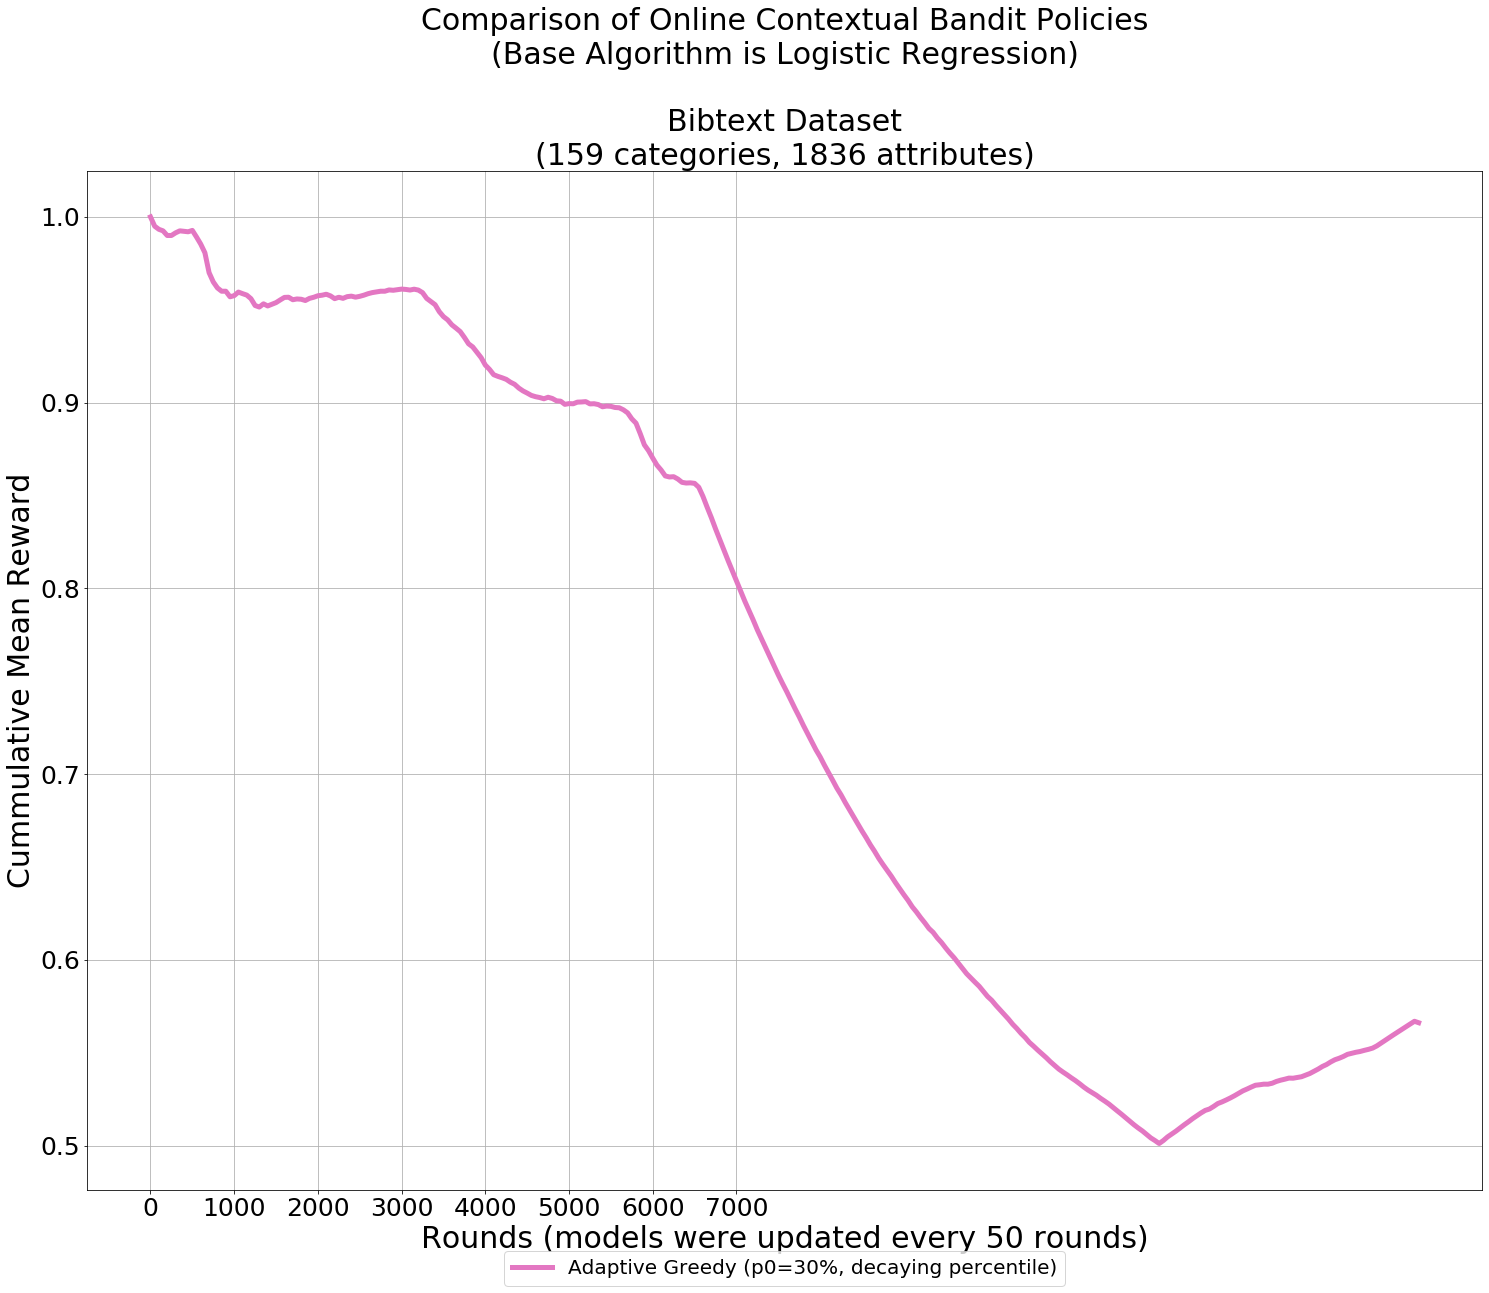

In [85]:
#batch size 100

import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
# plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper-Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
# plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[2])
# plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[4])
# plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999)",linewidth=lwd,color=colors[6])
# plt.plot(get_mean_reward(rewards_egr2), label="Epsilon-Greedy (p0=20%, no decay)",linewidth=lwd,color=colors[8])
# plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (decaying threshold)",linewidth=lwd,color=colors[10])
plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (p0=30%, decaying percentile)",linewidth=lwd,color=colors[12])
# plt.plot(get_mean_reward(rewards_efr), label="Explore First (n=1,500)",linewidth=lwd,color=colors[14])
# plt.plot(get_mean_reward(rewards_ac), label="Active Explorer", linewidth=lwd,color=colors[15])
# plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy", linewidth=lwd,color=colors[16])
# plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer", linewidth=lwd,color=colors[17])
# plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')


# import warnings
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)\n\nBibtext Dataset\n(159 categories, 1836 attributes)',size=30)
plt.grid()
plt.show()

In [ ]:
actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype('uint8')

In [86]:
idx = np.random.randint(len(X), size=50)
for i in idx:
  action = models[0].predict(X[idx, :]).astype("uint8")
  print(action)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

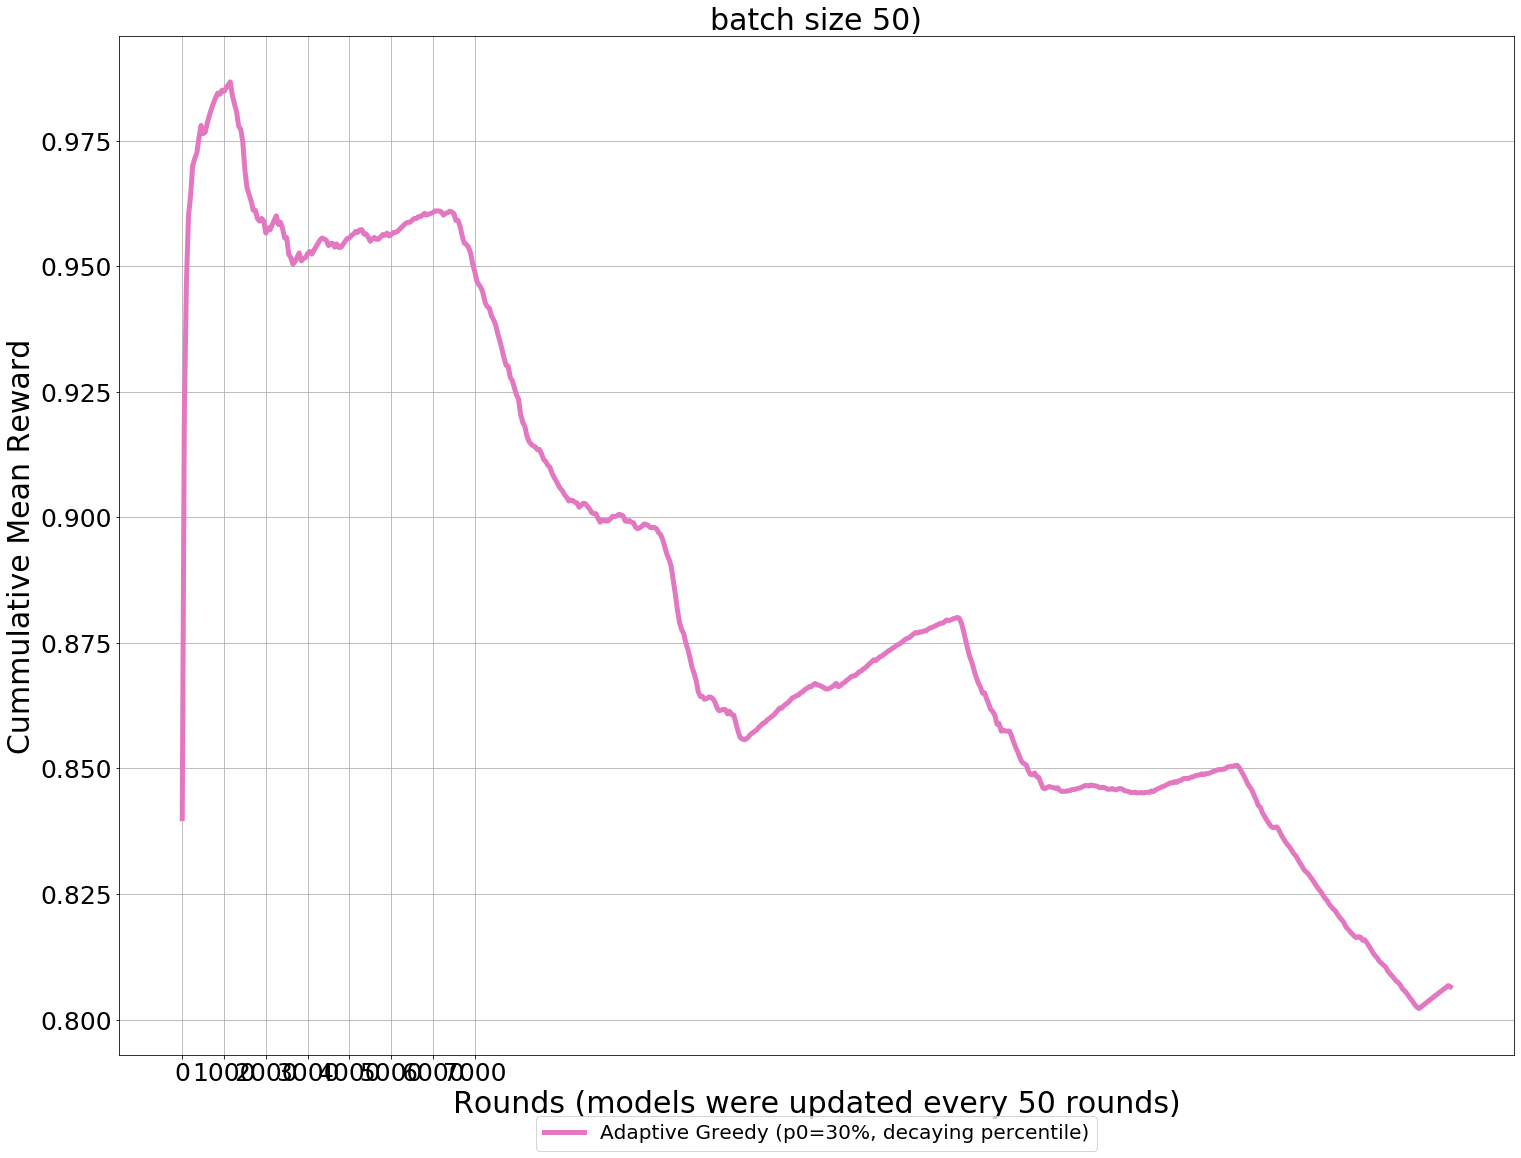

In [44]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
# plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper-Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
# plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[2])
# plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[4])
# plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999)",linewidth=lwd,color=colors[6])
# plt.plot(get_mean_reward(rewards_egr2), label="Epsilon-Greedy (p0=20%, no decay)",linewidth=lwd,color=colors[8])
# plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (decaying threshold)",linewidth=lwd,color=colors[10])
plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (p0=30%, decaying percentile)",linewidth=lwd,color=colors[12])
# plt.plot(get_mean_reward(rewards_efr), label="Explore First (n=1,500)",linewidth=lwd,color=colors[14])
# plt.plot(get_mean_reward(rewards_ac), label="Active Explorer", linewidth=lwd,color=colors[15])
# plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy", linewidth=lwd,color=colors[16])
# plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer", linewidth=lwd,color=colors[17])
# plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')


# import warnings
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('batch size 50)',size=30)
plt.grid()
plt.show()

In [51]:
idx = np.random.randint(len(X), size=4)
for i in idx:
  action = models[0].predict(X[idx, :]).astype("uint8")
  print(action, y[0])

[1 1 1 1] [1 0]
[1 1 1 1] [1 0]
[1 1 1 1] [1 0]
[1 1 1 1] [1 0]


In [9]:
from sklearn.linear_model import SGDClassifier

nchoices = y.shape[0]
base_algorithm = SGDClassifier(random_state=123, loss='log')
beta_prior = ((3, 7), 2) # until there are at least 2 observations of each class, will use prior Beta(3, 7)

## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
one_vs_rest = SeparateClassifiers(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
epsilon_greedy_nodecay = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                     beta_prior=beta_prior, decay=None, batch_train=True)
adaptive_greedy_thr = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                     decay_type='threshold', batch_train=True)
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                      decay_type='percentile', decay=0.9997, batch_train=True)
explore_first = ExploreFirst(deepcopy(base_algorithm), nchoices = nchoices,
                             beta_prior=None, explore_rounds=1500, batch_train=True)
active_explorer = ActiveExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                        active_choice='weighted', decay_type='percentile', decay=0.9997, batch_train=True)
softmax_explorer = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)

models = [bootstrapped_ucb, bootstrapped_ts, one_vs_rest, epsilon_greedy, epsilon_greedy_nodecay,
          adaptive_greedy_thr, adaptive_greedy_perc, explore_first, active_explorer,
          adaptive_active_greedy, softmax_explorer]

NameError: name 'BootstrappedUCB' is not defined

In [88]:
# These lists will keep track of the rewards obtained by each policy
rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2, \
rewards_agr, rewards_agr2, rewards_efr, rewards_ac, \
rewards_aac, rewards_sft = [list() for i in range(len(models))]

lst_rewards = [rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2,
               rewards_agr, rewards_agr2, rewards_efr, rewards_ac,
               rewards_aac, rewards_sft]

# batch size - algorithms will be refit after N rounds
batch_size=500

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    np.random.seed(123)
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose
lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr, \
lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, \
lst_a_sft = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr,
               lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac,lst_a_sft]

# rounds are simulated from the full dataset
def simulate_rounds_stoch(model, rewards, actions_hist, X_batch, y_batch, rnd_seed):
    np.random.seed(rnd_seed)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_batch).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_batch[np.arange(y_batch.shape[0]), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # rewards obtained now
    rewards_batch = y_batch[np.arange(y_batch.shape[0]), actions_this_batch]
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(rnd_seed)
    model.partial_fit(X_batch, actions_this_batch, rewards_batch)
    
    return new_actions_hist

# now running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    
    X_batch = X[batch_st:batch_end, :]
    y_batch = y[batch_st:batch_end, :]
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds_stoch(models[model],
                                                   lst_rewards[model],
                                                   lst_actions[model],
                                                   X_batch, y_batch,
                                                   rnd_seed = batch_st)

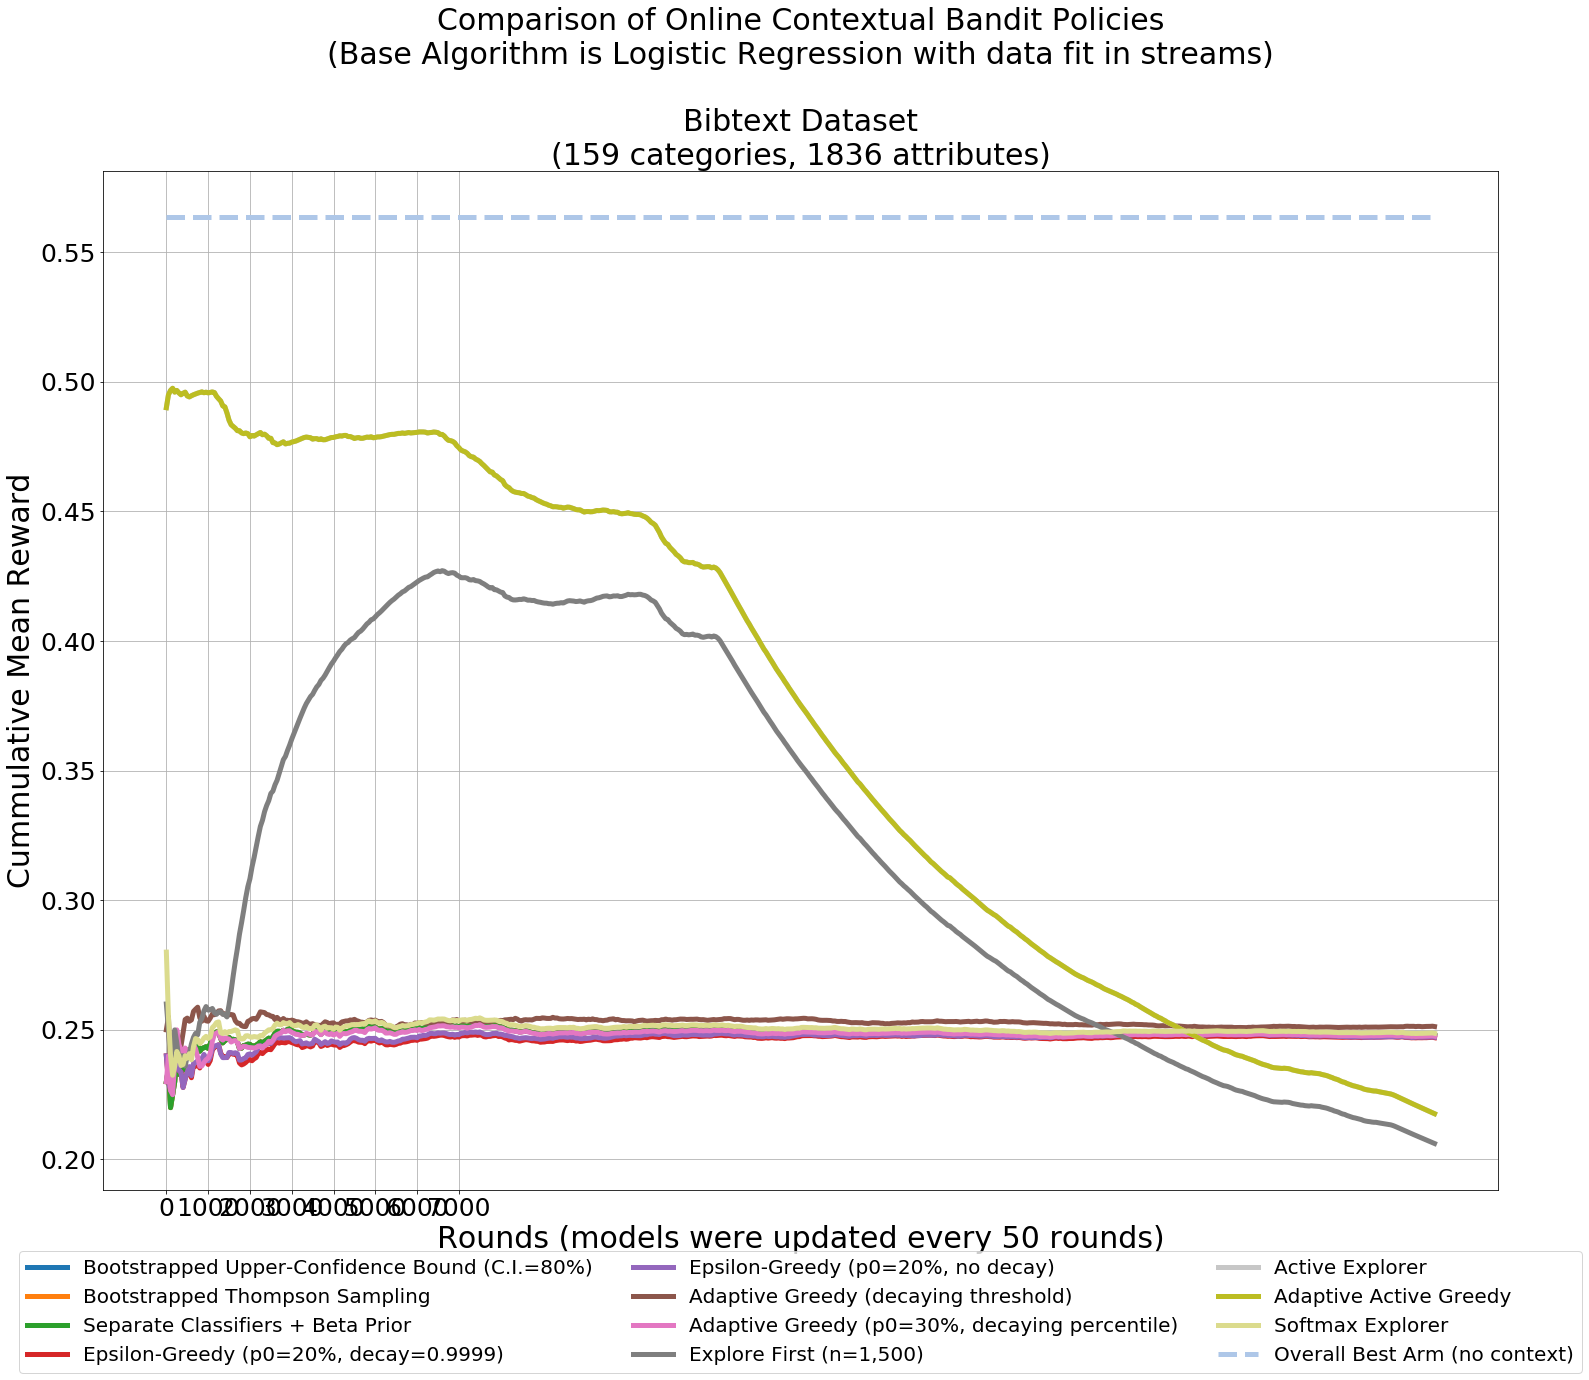

In [89]:


rcParams['figure.figsize'] = 25, 15

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper-Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[4])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999)",linewidth=lwd,color=colors[6])
plt.plot(get_mean_reward(rewards_egr2), label="Epsilon-Greedy (p0=20%, no decay)",linewidth=lwd,color=colors[8])
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (decaying threshold)",linewidth=lwd,color=colors[10])
plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (p0=30%, decaying percentile)",linewidth=lwd,color=colors[12])
plt.plot(get_mean_reward(rewards_efr), label="Explore First (n=1,500)",linewidth=lwd,color=colors[14])
plt.plot(get_mean_reward(rewards_ac), label="Active Explorer", linewidth=lwd,color=colors[15])
plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy", linewidth=lwd,color=colors[16])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer", linewidth=lwd,color=colors[17])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nBibtext Dataset\n(159 categories, 1836 attributes)',size=30)
plt.grid()
plt.show()

In [127]:
idx = np.random.randint(len(X), size=2)
for i in idx:
  action = models[3].predict(X[idx, :]).astype("uint8")
  print(action)

[1 0]
[1 0]


In [108]:
idx = np.random.randint(len(X), size=4)
for i in idx:
  action = models[4].predict(X[idx, :]).astype("uint8")
  print(action)

[0 0 0 0]
[0 0 1 0]
[1 0 1 0]
[0 0 1 0]


In [110]:
idx = np.random.randint(len(X), size=4)
for i in idx:
  action = models[5].predict(X[idx, :]).astype("uint8")
  print(action)

[0 1 0 0]
[1 0 0 0]
[0 1 0 1]
[0 0 1 1]


In [111]:
idx = np.random.randint(len(X), size=4)
for i in idx:
  action = models[6].predict(X[idx, :]).astype("uint8")
  print(action)

[1 0 0 0]
[0 0 1 0]
[1 0 1 1]
[0 0 1 1]


In [113]:
idx = np.random.randint(len(X), size=50)
for i in idx:
  action = models[7].predict(X[idx, :]).astype("uint8")
  print(action)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [114]:
idx = np.random.randint(len(X), size=50)
for i in idx:
  action = models[8].predict(X[idx, :]).astype("uint8")
  print(action)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [115]:
idx = np.random.randint(len(X), size=50)
for i in idx:
  action = models[9].predict(X[idx, :]).astype("uint8")
  print(action)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [116]:
idx = np.random.randint(len(X), size=40)
for i in idx:
  action = models[10].predict(X[idx, :]).astype("uint8")
  print(action)

[1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1
 0 0 0]
[0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 1 0 1 1
 0 0 0]
[0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 0 0 1 0 0 1 1 1
 0 0 0]
[0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1
 0 0 0]
[0 0 0 0 1 0 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0
 1 1 0]
[1 0 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0
 1 1 0]
[0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1
 1 0 1]
[1 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0
 0 1 1]
[1 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 0 0 1 0 0 1 1
 1 1 1]
[1 0 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1
 0 1 1]
[1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 1 1 1 0 0 0 1
 1 1 0]
[1 1 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 1 1 0 1 1 1 0 1 0 0 1 0 0 0 1
 1 1 0]
[0 0

In [93]:
action = models[0].predict(X[0, :]).astype("uint8")
print(action)

[1]


In [95]:
X[0, :]

array([ 1.20000000e+01,  7.66910000e+01,  1.32750000e+01,  3.55160000e+01,
        2.08000000e+01,  2.69000000e+02, -6.60000000e+01,  1.90000000e+01,
        3.02459097e+00,  9.09311111e-04,  1.43000000e-04,  1.90200000e-03,
        1.30000000e+01,  2.14748365e+09,  2.14748365e+09,  2.14748365e+09,
        2.14748365e+09,  2.14748365e+09,  2.29889000e+02,  8.32520000e+01,
        1.59719000e+02,  5.29260000e+01,  4.90000000e+02,  6.24229298e-03,
        2.96495278e-02,  2.49800000e-02,  5.44170000e-02,  1.02400000e+03,
        3.71703651e-02,  3.46078615e-01,  1.87936400e+03,  1.55340000e+01,
        4.31578817e-02,  4.10000391e-01,  8.84940000e+01,  7.36000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [2]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer

def parse_data(file_name):
    features = list()
    labels = list()
    with open(file_name, 'rt') as f:
        f.readline()
        for l in f:
            if bool(re.search("^[0-9]", l)):
                g = re.search("^(([0-9]{1,2},?)+)\s(.*)$", l)
                labels.append([int(i) for i in g.group(1).split(",")])
                features.append(eval("{" + re.sub("\s", ",", g.group(3)) + "}"))
            else:
                l = l.strip()
                labels.append([])
                features.append(eval("{" + re.sub("\s", ",", l) + "}"))
    features = pd.DataFrame.from_dict(features).fillna(0).iloc[:,:].values
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)
    return features, y

features, y = parse_data("data0215.txt")
print(features.shape)
print(y.shape)

(30433, 38)
(30433, 2)


In [ ]:
from sklearn.linear_model import LogisticRegression

# the 'explorer' polcy will be fit with this small sample of the rows
st_seed = 0
end_seed = 1000

# then it will choose actions for this larger sample
st_exploration = 0
end_exploration = 2000

# the new policy will be evaluated with a separate test set
st_test = 2000
end_test = 3000

# separating the covariates data for each case
Xseed = features[st_seed:end_seed, :]
Xexplore_sample = features[st_exploration:end_exploration, :]
Xtest = features[st_test:end_test, :]
nchoices = y.shape[0]

# now constructing an exploration policy as explained above, with fully-labeled data
explorer = LogisticRegression()
explorer.fit(Xseed, np.argmax(y[st_seed:end_seed], axis=1))

# letting the exploration policy choose actions for the new policy input
actions_explore_sample = explorer.predict(Xexplore_sample)
rewards_explore_sample = y[st_exploration:end_exploration, :]\
                        [np.arange(end_exploration - st_exploration), actions_explore_sample]

# extracting the probabilities it estimated
ix_internal_actions = {j:i for i,j in enumerate(explorer.classes_)}
ix_internal_actions = [ix_internal_actions[i] for i in actions_explore_sample]
ix_internal_actions = np.array(ix_internal_actions)
prob_actions_explore = explorer.predict_proba(Xexplore_sample)[np.arange(Xexplore_sample.shape[0]),
                                                               ix_internal_actions]

In [ ]:


from contextualbandits.online import SeparateClassifiers
from sklearn.linear_model import LogisticRegression

new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(), nchoices=y.shape[0],
                                 beta_prior=None, smoothing=None)
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
mean_reward_naive = np.mean(y[st_test:end_test, :]\
                             [np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Separate Classifiers: ", mean_reward_naive)



In [ ]:
from contextualbandits.online import SeparateClassifiers
from sklearn.linear_model import LogisticRegression

new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(), nchoices=y.shape[0],
                                 beta_prior="auto")
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
mean_reward_beta = np.mean(y[st_test:end_test, :]\
                            [np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Separate Classifiers + Prior: ", mean_reward_beta)

In [ ]:
from contextualbandits.online import SeparateClassifiers
from sklearn.linear_model import LogisticRegression

new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(), nchoices=y.shape[0],
                                 beta_prior=None, smoothing = (3,4))
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
mean_reward_sm = np.mean(y[st_test:end_test, :]\
                            [np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Separate Classifiers + Smoothing: ", mean_reward_sm)


In [ ]:
from contextualbandits.offpolicy import OffsetTree
from sklearn.linear_model import LogisticRegression

new_policy = OffsetTree(base_algorithm=LogisticRegression(), nchoices=y.shape[0])
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_ot = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Offset Tree technique: ", mean_reward_ot)

In [16]:
from contextualbandits.offpolicy import DoublyRobustEstimator
from sklearn.linear_model import LogisticRegression, Ridge

new_policy = DoublyRobustEstimator(base_algorithm = Ridge(),
                                   reward_estimator = LogisticRegression(),
                                   nchoices = y.shape[0],
                                   method = 'rovr', beta_prior = None, smoothing = None)
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_dr = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Doubly-Robust Estimator: ", mean_reward_dr)

IndexError: index 20806 is out of bounds for axis 1 with size 2

In [ ]:
new_policy = DoublyRobustEstimator(base_algorithm = Ridge(),
                                   reward_estimator = LogisticRegression(),
                                   nchoices = y.shape[0],
                                   method = 'rovr', beta_prior = "auto", smoothing = None)
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_dr_prior = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Doubly-Robust Estimator + Prior: ", mean_reward_dr_prior)

In [ ]:
import matplotlib.pyplot as plt, pandas as pd
import seaborn as sns
from pylab import rcParams
%matplotlib inline

results = pd.DataFrame({
    'Off-policy Learning Method' : ['Naive', 'Naive + Prior', 'Naive + Smoothing', 'Doubly-Robust',
                                    'Doubly-Robust + Prior', 'Doubly-Robust + Smoothing', 'Offset Tree'],
    'Test set mean reward' : [mean_reward_naive, mean_reward_beta, mean_reward_sm, mean_reward_dr,
                              mean_reward_dr_prior, mean_reward_dr_sm, mean_reward_ot]
})

sns.set(font_scale = 1.3)
rcParams['figure.figsize'] = 22, 7
sns.barplot(x = "Off-policy Learning Method", y="Test set mean reward", data=results)
plt.title('Off-policy Learning on Bibtex Dataset\nBase Classifier is Logistic Regression')
plt.show()

In [25]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer

def parse_data(file_name):
    features = list()
    labels = list()
    with open(file_name, 'rt') as f:
        f.readline()
        for l in f:
            if bool(re.search("^[0-9]", l)):
                g = re.search("^(([0-9]{1,2},?)+)\s(.*)$", l)
                labels.append([int(i) for i in g.group(1).split(",")])
                features.append(eval("{" + re.sub("\s", ",", g.group(3)) + "}"))
            else:
                l = l.strip()
                labels.append([])
                features.append(eval("{" + re.sub("\s", ",", l) + "}"))
    features = pd.DataFrame.from_dict(features).fillna(0).iloc[:,:].values
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)
    return features, y

X, y = parse_data("test.txt")

In [26]:
from sklearn.linear_model import SGDClassifier

nchoices = 2
base_algorithm = SGDClassifier(random_state=123, loss='log')
beta_prior = ((3, 7), 2) # until there are at least 2 observations of each class, will use prior Beta(3, 7)

## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
one_vs_rest = SeparateClassifiers(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
epsilon_greedy_nodecay = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                     beta_prior=beta_prior, decay=None, batch_train=True)
adaptive_greedy_thr = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                     decay_type='threshold', batch_train=True)
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                      decay_type='percentile', decay=0.9997, batch_train=True)
explore_first = ExploreFirst(deepcopy(base_algorithm), nchoices = nchoices,
                             beta_prior=None, explore_rounds=1500, batch_train=True)
active_explorer = ActiveExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                        active_choice='weighted', decay_type='percentile', decay=0.9997, batch_train=True)
softmax_explorer = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)

models = [bootstrapped_ucb, bootstrapped_ts, one_vs_rest, epsilon_greedy, epsilon_greedy_nodecay,
          adaptive_greedy_thr, adaptive_greedy_perc, explore_first, active_explorer,
          adaptive_active_greedy, softmax_explorer]

In [28]:
# These lists will keep track of the rewards obtained by each policy
rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2, \
rewards_agr, rewards_agr2, rewards_efr, rewards_ac, \
rewards_aac, rewards_sft = [list() for i in range(len(models))]

lst_rewards = [rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2,
               rewards_agr, rewards_agr2, rewards_efr, rewards_ac,
               rewards_aac, rewards_sft]

# batch size - algorithms will be refit after N rounds
batch_size=10

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    np.random.seed(123)
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose
lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr, \
lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, \
lst_a_sft = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr,
               lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac,lst_a_sft]

# rounds are simulated from the full dataset
def simulate_rounds_stoch(model, rewards, actions_hist, X_batch, y_batch, rnd_seed):
    np.random.seed(rnd_seed)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_batch).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_batch[np.arange(y_batch.shape[0]), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # rewards obtained now
    rewards_batch = y_batch[np.arange(y_batch.shape[0]), actions_this_batch]
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(rnd_seed)
    model.partial_fit(X_batch, actions_this_batch, rewards_batch)
    
    return new_actions_hist

# now running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    
    X_batch = X[batch_st:batch_end, :]
    y_batch = y[batch_st:batch_end, :]
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds_stoch(models[model],
                                                   lst_rewards[model],
                                                   lst_actions[model],
                                                   X_batch, y_batch,
                                                   rnd_seed = batch_st)

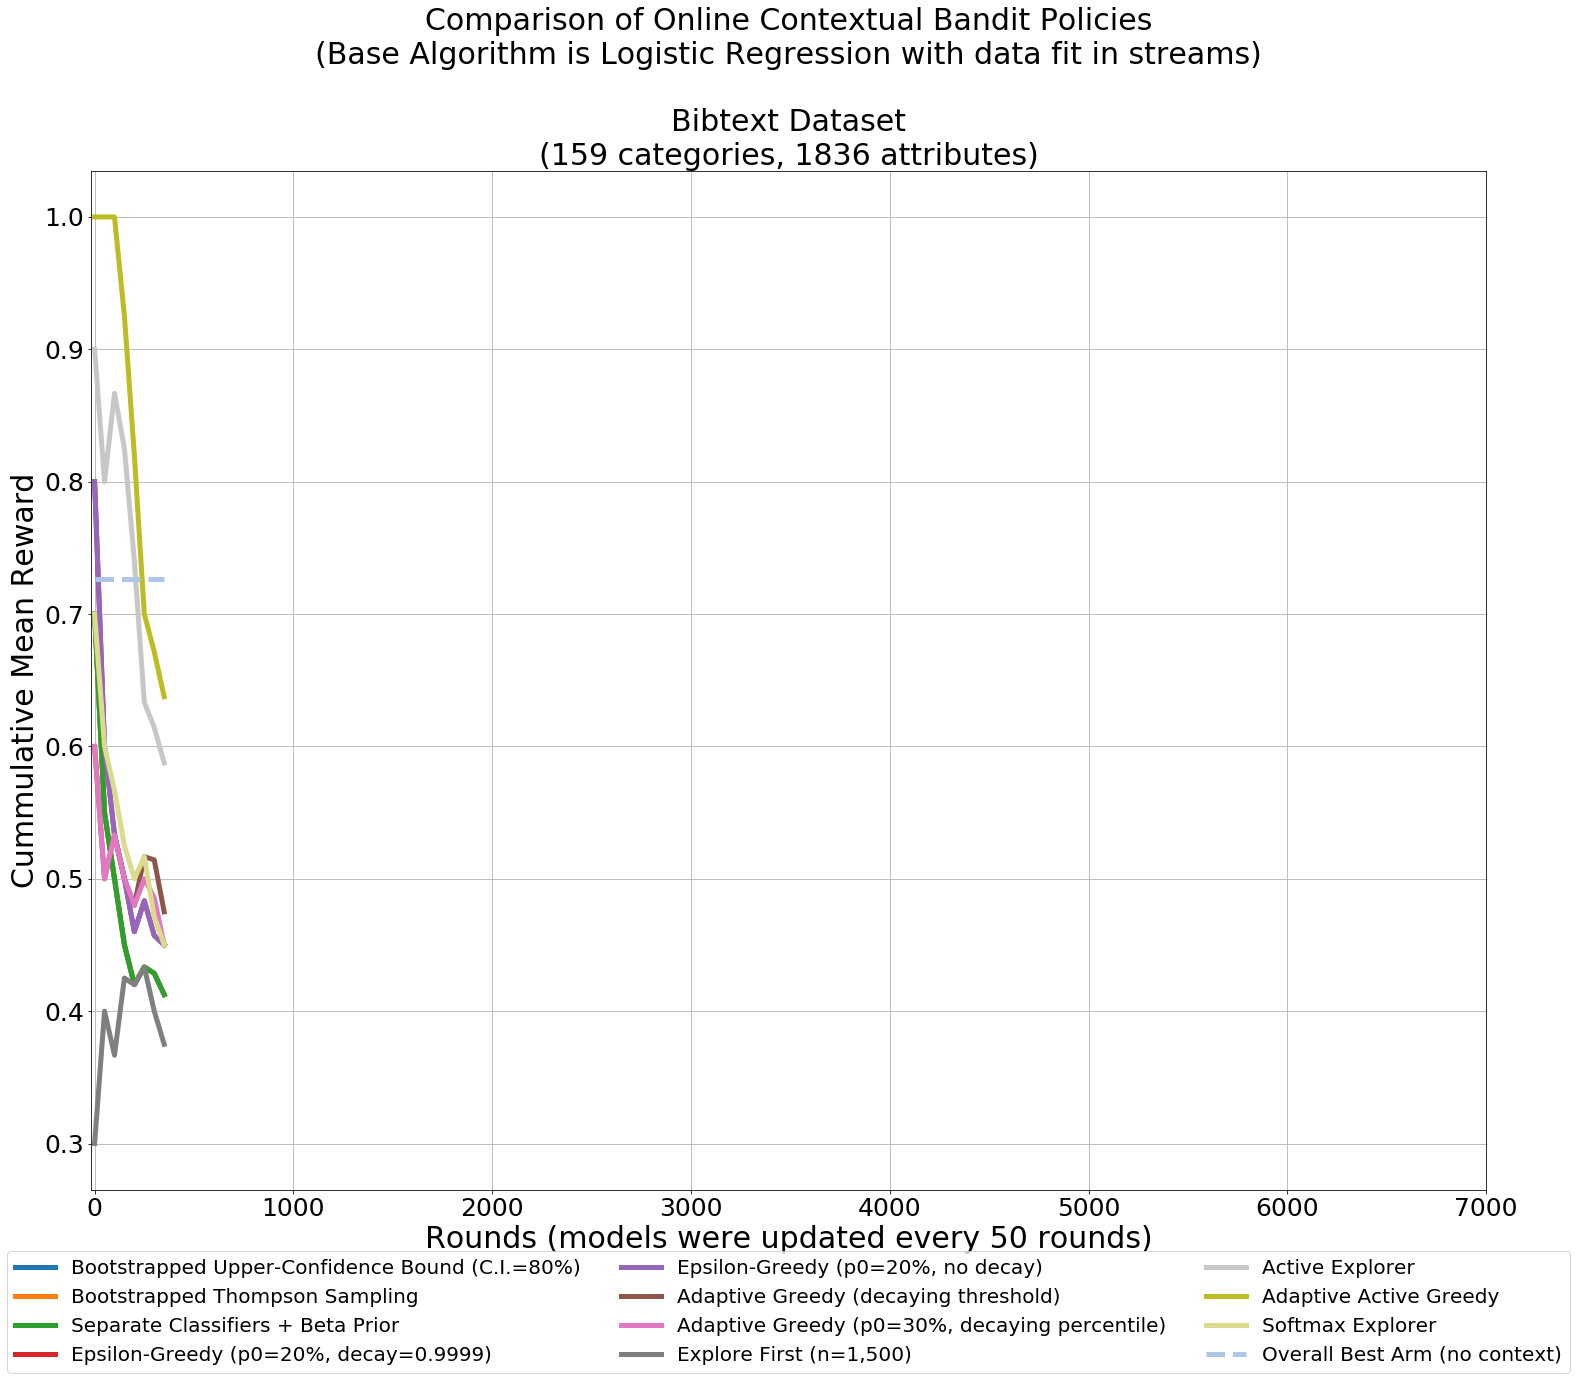

In [30]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper-Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[4])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999)",linewidth=lwd,color=colors[6])
plt.plot(get_mean_reward(rewards_egr2), label="Epsilon-Greedy (p0=20%, no decay)",linewidth=lwd,color=colors[8])
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (decaying threshold)",linewidth=lwd,color=colors[10])
plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (p0=30%, decaying percentile)",linewidth=lwd,color=colors[12])
plt.plot(get_mean_reward(rewards_efr), label="Explore First (n=1,500)",linewidth=lwd,color=colors[14])
plt.plot(get_mean_reward(rewards_ac), label="Active Explorer", linewidth=lwd,color=colors[15])
plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy", linewidth=lwd,color=colors[16])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer", linewidth=lwd,color=colors[17])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nBibtext Dataset\n(159 categories, 1836 attributes)',size=30)
plt.grid()
plt.show()



In [33]:
idx = np.random.randint(len(X), size=10)
for i in idx:
  action = models[0].predict(X[idx, :]).astype("uint8")
  print(action)

[1 1 0 1 0 0 0 0 0 1]
[1 0 0 1 1 0 1 1 0 1]
[1 1 1 0 0 0 1 1 0 1]
[0 0 0 0 1 1 1 0 0 1]
[1 0 0 1 0 0 1 1 0 0]
[0 1 0 0 1 1 0 0 1 1]
[0 0 1 0 1 1 0 1 1 1]
[1 0 1 1 0 0 0 1 1 1]
[1 1 0 1 0 1 1 1 1 1]
[0 1 1 1 1 0 1 0 1 1]


In [34]:
idx = np.random.randint(len(X), size=10)
for i in idx:
  action = models[1].predict(X[idx, :]).astype("uint8")
  print(action)

[0 0 0 1 0 0 1 1 0 0]
[0 0 0 0 1 0 0 1 1 1]
[1 0 1 1 0 0 1 1 0 1]
[0 0 1 1 1 1 1 1 0 1]
[1 1 1 1 0 1 0 1 1 1]
[1 1 0 0 0 0 1 0 0 1]
[1 0 0 1 0 1 0 1 1 0]
[0 1 1 1 1 1 1 0 1 1]
[1 1 1 1 1 1 0 0 1 0]
[1 0 1 1 0 1 1 0 1 0]


In [35]:
idx = np.random.randint(len(X), size=10)
for i in idx:
  action = models[2].predict(X[idx, :]).astype("uint8")
  print(action)

[0 1 0 0 1 0 1 1 0 1]
[1 1 0 1 0 0 1 0 1 1]
[0 1 1 0 1 0 1 1 1 0]
[0 1 1 1 1 1 0 0 0 1]
[1 1 1 0 1 0 0 0 1 1]
[0 1 0 1 0 1 1 0 0 1]
[0 0 1 1 0 0 1 1 0 1]
[0 1 1 0 1 1 0 0 1 1]
[0 0 0 1 0 0 1 0 0 0]
[1 1 1 1 1 0 1 1 0 1]


In [36]:
idx = np.random.randint(len(X), size=10)
for i in idx:
  action = models[3].predict(X[idx, :]).astype("uint8")
  print(action)

[1 0 0 0 1 1 1 0 1 1]
[1 1 1 1 0 0 0 1 1 1]
[1 1 0 0 0 0 0 0 1 0]
[1 0 1 1 0 0 0 1 1 0]
[1 1 1 0 1 0 1 0 1 1]
[0 1 1 1 1 1 1 1 1 1]
[1 0 0 0 0 1 1 1 0 0]
[1 1 0 0 1 1 0 0 0 1]
[0 1 0 1 1 0 0 0 1 0]
[0 0 1 1 0 1 0 1 1 0]


In [37]:
idx = np.random.randint(len(X), size=10)
for i in idx:
  action = models[4].predict(X[idx, :]).astype("uint8")
  print(action)

[1 1 0 0 0 0 1 0 1 0]
[1 0 0 0 0 0 1 0 1 1]
[1 0 1 1 0 1 0 1 1 0]
[0 0 1 0 0 0 0 1 0 1]
[0 0 0 1 0 0 0 1 0 1]
[0 1 0 1 0 0 0 1 0 0]
[1 0 0 0 1 1 1 0 0 0]
[0 1 1 0 1 1 1 0 1 1]
[1 1 0 0 0 1 1 0 0 0]
[1 0 1 1 1 1 1 0 0 1]


In [39]:
idx = np.random.randint(len(X), size=8)
for i in idx:
  action = models[5].predict(X[idx, :]).astype("uint8")
  print(action)

[1 0 0 1 0 1 0 1]
[0 1 0 1 1 0 0 1]
[0 1 0 1 0 0 1 1]
[1 0 1 1 1 1 0 0]
[0 0 0 1 0 1 0 0]
[0 1 0 1 1 0 0 0]
[1 0 1 1 0 1 0 1]
[1 0 1 1 0 0 0 0]
